# Dogs&Cats classification with Deep LearningDogs&Cats classification with Deep Learning
## *Find the best model*

![Dogs and cats](https://i.imgur.com/aVdtgUc.pnghttps://i.imgur.com/aVdtgUc.png)

# Table of contents

[<h3>1. Data preprocessing and visualization</h3>](#1)

[<h3>2. Load the Images with a generator and Data Augmentation</h3>](#2)

[<h3>3. Test 27 canned architectures with pre-trained weights</h3>](#3)

[<h3>4. Train the best architecture</h3>](#4)

[<h3>5. Examples of prediction</h3>](#5)

# 1. Data preprocessing and visualization<a class="anchor" id="1"></a><a class="anchor" id="1"></a>

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from time import perf_counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [2]:
# Create a list with the filepaths for training and testing
dir_ = Path('../input/dogs-cats-images/dataset/training_set')
train_filepaths = list(dir_.glob(r'**/*.jpg'))

dir_ = Path('../input/dogs-cats-images/dataset/test_set')
test_filepaths = list(dir_.glob(r'**/*.jpg'))

In [3]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)

print(f'Number of pictures in the training dataset: {train_df.shape[0]}\n')
print(f'Number of pictures in the test dataset: {test_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

Number of pictures in the training dataset: 8000

Number of pictures in the test dataset: 2000

Number of different labels: 2

Labels: ['dogs' 'cats']


,Filepath,Label
0,../input/dogs-cats-images/dataset/training_set...,dogs
1,../input/dogs-cats-images/dataset/training_set...,dogs
2,../input/dogs-cats-images/dataset/training_set...,cats
3,../input/dogs-cats-images/dataset/training_set...,dogs
4,../input/dogs-cats-images/dataset/training_set...,dogs


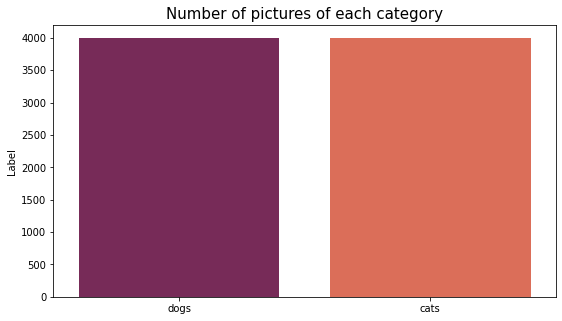

In [4]:
# Display the number of pictures of each category
vc = train_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

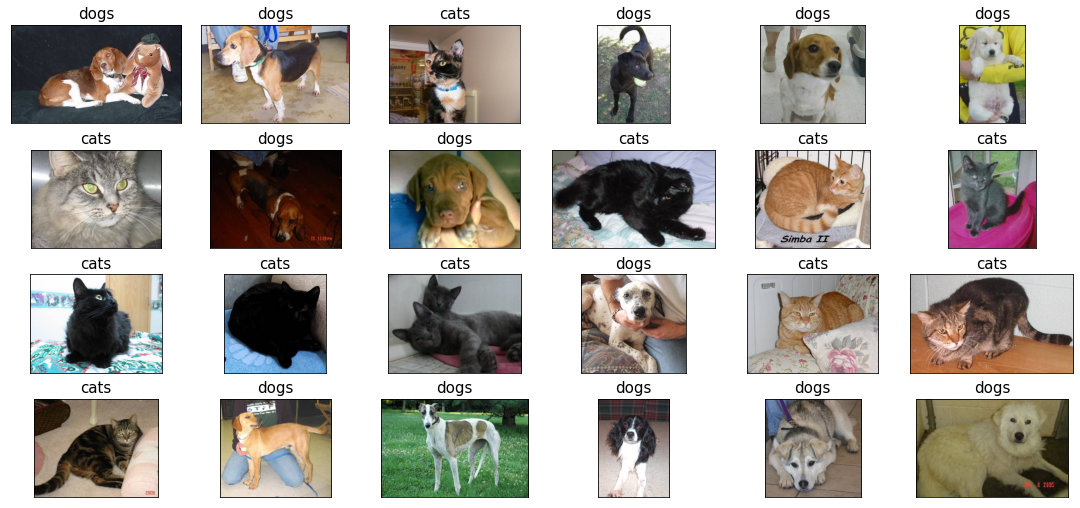

In [5]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.Filepath[i]))
    ax.set_title(train_df.Label[i], fontsize = 15)
plt.tight_layout(pad=0.5)
plt.show()

# 2. Load the Images with a generator and Data Augmentation<a class="anchor" id="2"></a><a class="anchor" id="1"></a>

In [6]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

# 3. Test 27 canned architectures with pre-trained weights<a class="anchor" id="3"></a><a class="anchor" id="1"></a>

More info about the architectures under: [Module: tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=enhttps://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=en)

In [7]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [8]:
# Dictionary with the models
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "EfficientNetB2": {"model":tf.keras.applications.EfficientNetB2, "perf":0},
    "EfficientNetB3": {"model":tf.keras.applications.EfficientNetB3, "perf":0},
    "EfficientNetB4": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB5": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB6": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB7": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "MobileNetV3Small": {"model":tf.keras.applications.MobileNetV3Small, "perf":0},
#     "NASNetLarge": {"model":tf.keras.applications.NASNetLarge, "perf":0}, Deleted because the input shape has to be another one
    "NASNetMobile": {"model":tf.keras.applications.NASNetMobile, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
    "ResNet101V2": {"model":tf.keras.applications.ResNet101V2, "perf":0},
    "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

# Fit the models
for name, model in models.items():
    
    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # Sav the duration and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 7200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


DenseNet121          trained in 40.31 sec
MobileNetV2          trained in 32.11 sec
51879936/51877672 [==============================] - 0s 0us/step
DenseNet169          trained in 43.38 sec
DenseNet201          trained in 46.73 sec
16711680/16705208 [==============================] - 0s 0us/step
EfficientNetB0       trained in 37.3 sec
27025408/27018416 [==============================] - 0s 0us/step
EfficientNetB1       trained in 39.81 sec
31793152/31790344 [==============================] - 0s 0us/step
EfficientNetB2       trained in 40.33 sec
43941888/43941136 [==============================] - 0s 0us/step
EfficientNetB3       trained in 43.32 sec
71688192/71686520 [==============================] - 0s 0us/step
EfficientNetB4       trained in 46.86 sec
EfficientNetB5       trained in 47.32 sec
Efficie

In [9]:
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)

In [10]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,val_accuracy,accuracy,Training time (sec)
0,DenseNet201,0.9937,0.9930,46.73
1,DenseNet121,0.9950,0.9920,40.31
2,InceptionResNetV2,0.9900,0.9915,47.28
3,NASNetMobile,0.9900,0.9880,45.87
4,DenseNet169,0.9937,0.9875,43.38
5,ResNet50V2,0.9937,0.9875,33.58
6,ResNet152V2,0.9887,0.9870,46.73
7,Xception,0.9862,0.9860,36.43
8,ResNet101V2,0.9937,0.9855,39.87
9,MobileNetV2,0.9787,0.9850,32.11


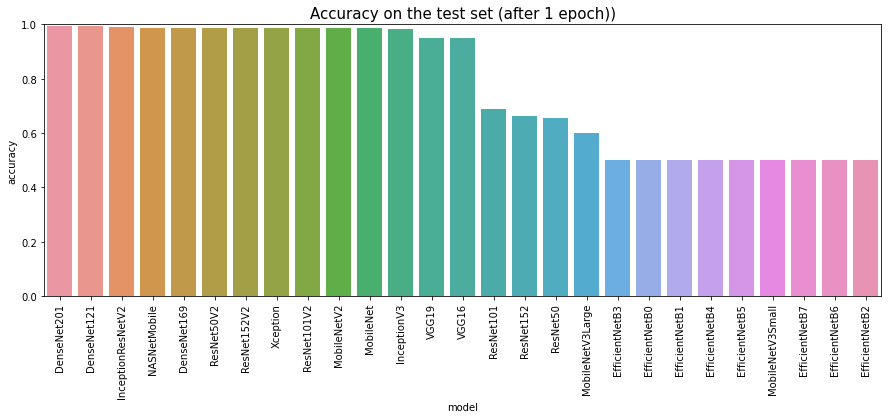

In [27]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

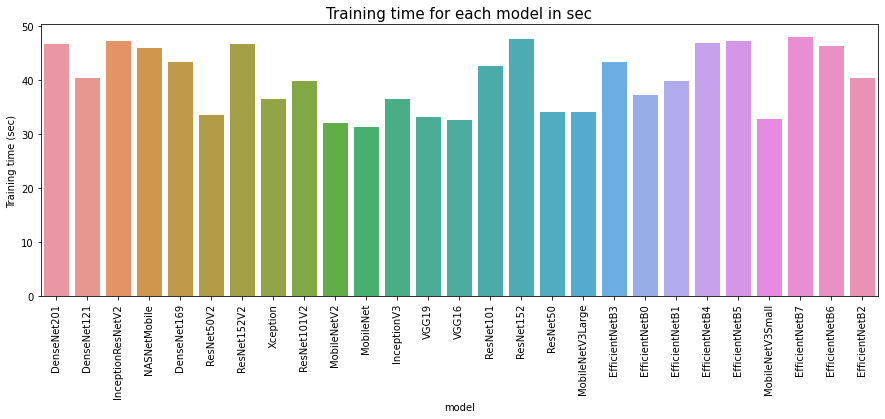

In [28]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
plt.xticks(rotation=90)
plt.show()

# 4. Train the architecture with the best result (DenseNet201)<a class="anchor" id="4"></a><a class="anchor" id="1"></a>
*With more than one epoch*

In [19]:
# Create and train the model
model = get_model(tf.keras.applications.DenseNet201)
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=50,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=10,
                            restore_best_weights=True)]
                    )

Epoch 1/50
225/225 [==============================] - 45s 160ms/step - loss: 0.0794 - accuracy: 0.9740 - val_loss: 0.0268 - val_accuracy: 0.9950
Epoch 2/50
225/225 [==============================] - 33s 148ms/step - loss: 0.0222 - accuracy: 0.9908 - val_loss: 0.0176 - val_accuracy: 0.9925
Epoch 3/50
225/225 [==============================] - 34s 149ms/step - loss: 0.0108 - accuracy: 0.9959 - val_loss: 0.0276 - val_accuracy: 0.9925
Epoch 4/50
225/225 [==============================] - 35s 153ms/step - loss: 0.0105 - accuracy: 0.9959 - val_loss: 0.0247 - val_accuracy: 0.9950
Epoch 5/50
225/225 [==============================] - 34s 150ms/step - loss: 0.0090 - accuracy: 0.9967 - val_loss: 0.0684 - val_accuracy: 0.9825
Epoch 6/50
225/225 [==============================] - 33s 148ms/step - loss: 0.0058 - accuracy: 0.9968 - val_loss: 0.0386 - val_accuracy: 0.9912
Epoch 7/50
225/225 [==============================] - 33s 147ms/step - loss: 0.0045 - accuracy: 0.9982 - val_loss: 0.0449 - val_ac

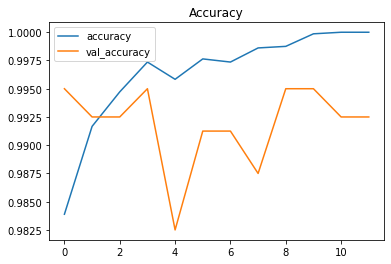

In [20]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

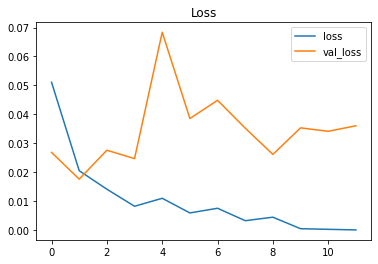

In [21]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [22]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Get the accuracy on the test set
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
printmd(f'# Accuracy on the test set: {acc * 100:.2f}%')

# Accuracy on the test set: 99.25%

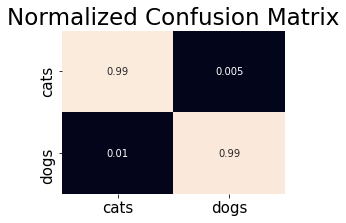

In [23]:
# Display a confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (4,3))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# 5. Examples of prediction<a class="anchor" id="5"></a><a class="anchor" id="1"></a>


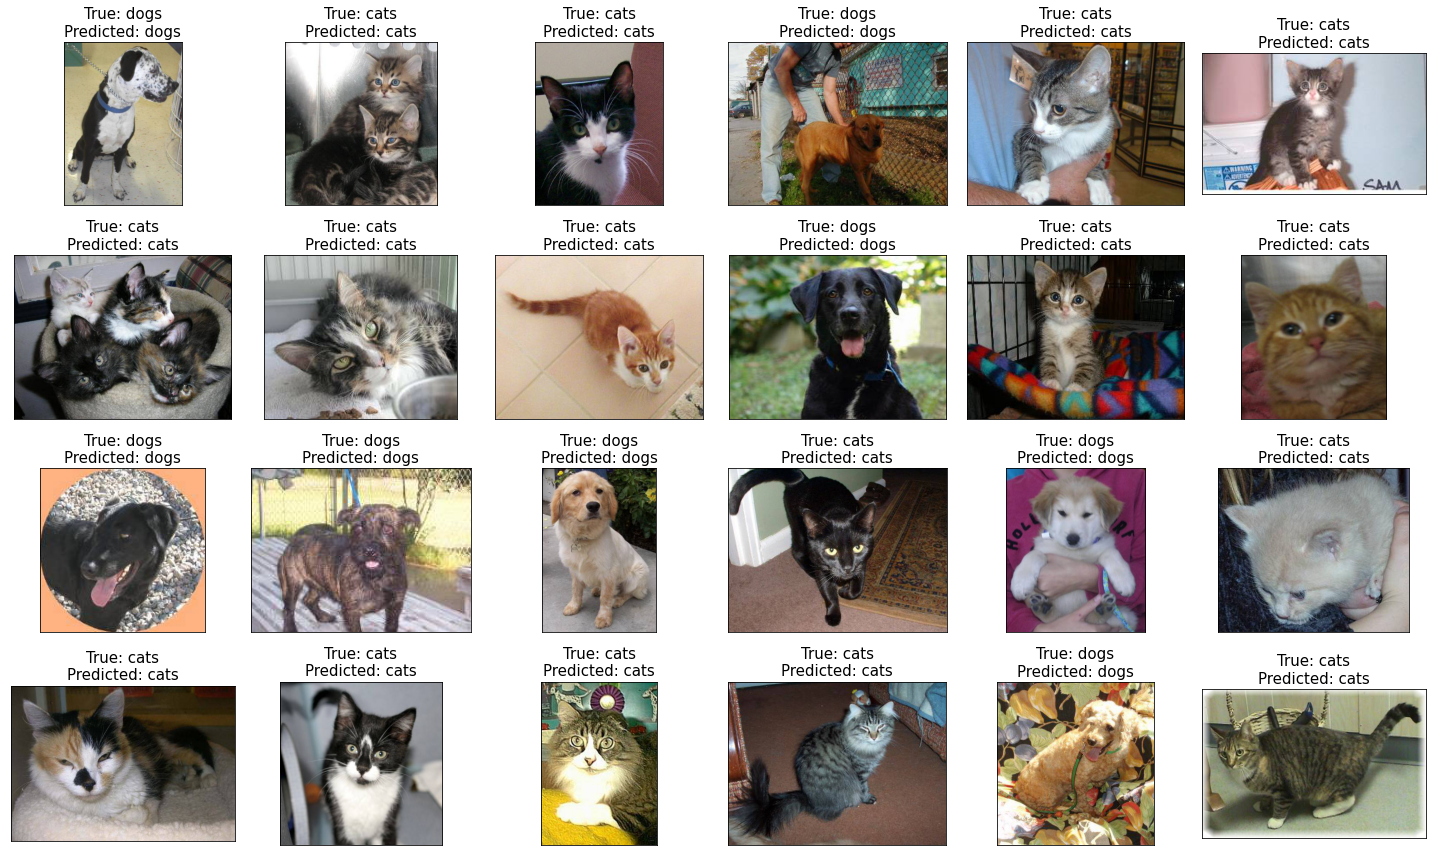

In [24]:
# Display picture of the dataset with their labels
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()